<a href="https://colab.research.google.com/github/unknown-aiby/PINNs/blob/main/stefan1d2p.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import timeit

class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name=None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name

    def sample(self, N):
        x = self.coords[0:1, :] + (self.coords[1:2, :] - self.coords[0:1, :]) * np.random.uniform(0, 1, size=(N, self.dim))
        y = self.func(x)
        return x, y

class DataSampler:
    # Initialize the class
    def __init__(self, X, Y, name = None):
        self.X = X
        self.Y = Y
        self.N = self.X.shape[0]

    def sample(self, batch_size):
        idx = np.random.choice(self.N, batch_size, replace=True)
        X_batch = self.X[idx, :]
        Y_batch = self.Y[idx, :]
        return X_batch, Y_batch

class Stefan1D_2P_direct:
    def __init__(self, layers_u, layers_s, bcs_sampler, ics_sampler, res_sampler):
        # Normalization constants
        X, _ = res_sampler.sample(np.int32(1e5))
        self.mu_X, self.sigma_X = X.mean(0), X.std(0)
        self.mu_x, self.sigma_x = self.mu_X[0], self.sigma_X[0]
        self.mu_t, self.sigma_t = self.mu_X[1], self.sigma_X[1]

        # Samplers
        self.bcs_sampler = bcs_sampler
        self.ics_sampler = ics_sampler
        self.res_sampler = res_sampler

        # Initialize network weights and biases
        self.layers_u = layers_u
        self.weights_u, self.biases_u = self.initialize_NN(layers_u)

        self.layers_s = layers_s
        self.weights_s, self.biases_s = self.initialize_NN(layers_s)

        # Define Tensorflow session
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

        # Define placeholders and computational graph
        self.x_u_tf = tf.placeholder(tf.float32, shape=(None, 1))  # [0, 1]
        self.t_u_tf = tf.placeholder(tf.float32, shape=(None, 1))  # [0, 1]

        self.t_0_tf = tf.placeholder(tf.float32, shape=(None, 1))  # t = 0
        self.s_0_tf = tf.placeholder(tf.float32, shape=(None, 1))  # s(0)

        self.x_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.x_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.x_ic1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_ic1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_ic1_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.x_ic2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_ic2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_ic2_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.x_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_r_tf = tf.placeholder(tf.float32, shape=(None, 1))

        # Evaluate predictions
        self.s_pred = self.net_s(self.t_u_tf)
        self.u1_pred, self.u2_pred = self.net_u1u2(self.x_r_tf, self.t_r_tf)
        self.u_pred = self.net_u(self.x_u_tf, self.t_u_tf)

        self.u1_0_pred,_ = self.net_u1u2(self.x_ic1_tf, self.t_ic1_tf)
        _, self.u2_0_pred = self.net_u1u2(self.x_ic2_tf, self.t_ic2_tf)

        self.u1_bc_pred, _ = self.net_u1u2(self.x_bc1_tf, self.t_bc1_tf)
        _, self.u2_bc_pred = self.net_u1u2(self.x_bc2_tf, self.t_bc2_tf)

        self.s_bc1_pred, self.s_bc2_pred = self.net_u1u2((self.net_s(self.t_r_tf) - self.mu_x) / self.sigma_x, self.t_r_tf)

        self.r_u1_pred, self.r_u2_pred = self.net_r_u1u2(self.x_r_tf, self.t_r_tf)

        self.r_Nc_pred = self.net_r_Nc(self.t_r_tf)

        # Boundary loss
        self.loss_u1_bc = tf.reduce_mean(tf.square(self.u1_bc_pred - self.u_bc1_tf))
        self.loss_u2_bc = tf.reduce_mean(tf.square(self.u2_bc_pred - self.u_bc2_tf))
        self.loss_u_bcs = self.loss_u1_bc + self.loss_u2_bc

        # Initial Loss
        self.loss_u1_ic = tf.reduce_mean(tf.square(self.u1_0_pred - self.u_ic1_tf))
        self.loss_u2_ic = tf.reduce_mean(tf.square(self.u2_0_pred - self.u_ic2_tf))
        self.loss_u_ics = self.loss_u1_ic + self.loss_u2_ic

        # Stefan loss
        self.loss_Sbc1 = tf.reduce_mean(tf.square(self.s_bc1_pred))  # u1(s(t),t) = u2(s(t), t) = 0
        self.loss_Sbc2 = tf.reduce_mean(tf.square(self.s_bc2_pred))  # u1(s(t),t) = u2(s(t), t) = 0
        self.loss_s_0 = tf.reduce_mean(tf.square(self.net_s(self.t_ic1_tf) - 0.5))  # s(0) = 0.5
        self.loss_SNc = tf.reduce_mean(tf.square(self.r_Nc_pred))   # Neumann Condition

        self.loss_Scs = self.loss_Sbc1 + self.loss_Sbc2 + self.loss_s_0 + self.loss_SNc

        # Residual loss
        self.loss_res_u1 = tf.reduce_mean(tf.square(self.r_u1_pred))
        self.loss_res_u2 = tf.reduce_mean(tf.square(self.r_u2_pred))
        self.loss_res = self.loss_res_u1 + self.loss_res_u2

        # Total loss
        self.loss = self.loss_res + self.loss_u_ics + self.loss_u_bcs + self.loss_Scs

        # Define optimizer with learning rate schedule
        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 1e-3
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,
                                                        1000, 0.9, staircase=False)
        # Passing global_step to minimize() will increment it at each step.
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)

        self.loss_bcs_log = []
        self.loss_ics_log = []
        self.loss_Scs_log = []
        self.loss_res_log = []
        self.saver = tf.train.Saver()

        # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

    # Xavier initialization
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
        return tf.Variable(tf.random.normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev,
                           dtype=tf.float32)

    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    # Evaluates the forward pass
    def forward_pass(self, H, weights, biases):
        num_layers = len(weights)
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H

    # Forward pass for u1, u2
    def net_u1u2(self, x, t):
        u = self.forward_pass(tf.concat([x, t], 1), self.weights_u, self.biases_u)
        u1 = u[:,0:1]
        u2 = u[:,1:2]
        return u1, u2

    def net_u1u2_x(self, x, t):
        u1, u2 = self.net_u1u2(x, t)
        u1_x = tf.gradients(u1, x)[0] / self.sigma_x
        u2_x = tf.gradients(u2, x)[0] / self.sigma_x
        
        return u1_x, u2_x

    # Forward pass for u
    def net_s(self, t):
        s = self.forward_pass(t, self.weights_s, self.biases_s)
        return s

    # Forward pass for u
    def net_u(self, x, t):
        u1, u2 = self.net_u1u2(x, t)
        s = self.net_s(t)  # consider normalization

        # demoralizing x coordinates
        x_hat = x * self.sigma_x + self.mu_x
        # consider s = x_hat
        u = tf.multiply(u1, 0.5 * (tf.sign(s - x_hat) + 1)) + tf.multiply(u2, 0.5 * (tf.sign(x_hat - s) + 1))
        return u

    # Forward pass for residual
    def net_r_u1u2(self, x, t):
        u1, u2 = self.net_u1u2(x, t)
        
        u1_t = tf.gradients(u1, t)[0] / self.sigma_t
        u1_x = tf.gradients(u1, x)[0] / self.sigma_x
        u1_xx = tf.gradients(u1_x, x)[0] / self.sigma_x
        r_u1 = u1_t - 2 * u1_xx

        u2_t = tf.gradients(u2, t)[0] / self.sigma_t
        u2_x = tf.gradients(u2, x)[0] / self.sigma_x
        u2_xx = tf.gradients(u2_x, x)[0] / self.sigma_x
        r_u2 = u2_t - u2_xx
        
        return r_u1, r_u2

    def net_r_Nc(self, t):
        s = self.net_s(t)
        s_t = tf.gradients(s, t)[0] / self.sigma_t

        # Normalizing s
        s = (s - self.mu_x) / self.sigma_x

        u1_x, u2_x = self.net_u1u2_x(s, t)

        residual = s_t - u2_x + 2 * u1_x
        return residual

    def fetch_minibatch(self, sampler, N):
        X, Y = sampler.sample(N)
        X = (X - self.mu_X) / self.sigma_X
        return X, Y

    def train(self, nIter=10000, batch_size=128):
        start_time = timeit.default_timer()

        for it in range(nIter):
            # Fetch boundary and data mini-batches
            X_bc1_batch, u1_bc_batch = self.fetch_minibatch(self.bcs_sampler[0], batch_size)
            X_bc2_batch, u2_bc_batch = self.fetch_minibatch(self.bcs_sampler[1], batch_size)
            X_ic1_batch, u1_ic_batch = self.fetch_minibatch(self.ics_sampler[0], batch_size)
            X_ic2_batch, u2_ic_batch = self.fetch_minibatch(self.ics_sampler[1], batch_size)

            # Fetch residual mini-batch
            X_res_batch, _ = self.fetch_minibatch(self.res_sampler, batch_size)

            # Define a dictionary for associating placeholders with data
            tf_dict = {self.x_u_tf: X_res_batch[:, 0:1], self.t_u_tf: X_res_batch[:, 1:2],
                       self.x_bc1_tf: X_bc1_batch[:, 0:1], self.t_bc1_tf: X_bc1_batch[:, 1:2],
                       self.u_bc1_tf: u1_bc_batch,
                       self.x_bc2_tf: X_bc2_batch[:, 0:1], self.t_bc2_tf: X_bc2_batch[:, 1:2],
                       self.u_bc2_tf: u2_bc_batch,
                       self.x_ic1_tf: X_ic1_batch[:, 0:1], self.t_ic1_tf: X_ic1_batch[:, 1:2],
                       self.u_ic1_tf: u1_ic_batch,
                       self.x_ic2_tf: X_ic2_batch[:, 0:1], self.t_ic2_tf: X_ic2_batch[:, 1:2],
                       self.u_ic2_tf: u2_ic_batch,
                       self.x_r_tf: X_res_batch[:, 0:1], self.t_r_tf: X_res_batch[:, 1:2]}

            self.sess.run(self.train_op, tf_dict)

            # Print
            if it % 10 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_bcs_value, loss_ics_value, loss_res_value = self.sess.run(
                    [self.loss_u_bcs, self.loss_u_ics, self.loss_res], tf_dict)
                self.loss_bcs_log.append(loss_bcs_value)
                self.loss_ics_log.append(loss_ics_value)
                self.loss_res_log.append(loss_res_value)
                print('It: %d, Loss: %.3e, Loss_bcs: %.3e, Loss_ics: %.3e, Loss_res: %.3e, Time: %.2f' %
                      (it, loss_value, loss_bcs_value, loss_ics_value, loss_res_value, elapsed))
                start_time = timeit.default_timer()

    # Predictions for u
    def predict_u(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.x_u_tf: X_star[:, 0:1], self.t_u_tf: X_star[:, 1:2]}
        u_star = self.sess.run(self.u_pred, tf_dict)
        return u_star

    # Predictions for s
    def predict_s(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.t_u_tf: X_star[:, 1:2]}
        s_star = self.sess.run(self.s_pred, tf_dict)
        return s_star


Device mapping: no known devices.
It: 0, Loss: 2.672e+00, Loss_bcs: 1.592e+00, Loss_ics: 3.024e-01, Loss_res: 2.417e-01, Time: 1.55
It: 10, Loss: 1.718e+00, Loss_bcs: 8.415e-01, Loss_ics: 1.318e-01, Loss_res: 2.549e-01, Time: 0.19
It: 20, Loss: 1.309e+00, Loss_bcs: 7.416e-01, Loss_ics: 1.431e-01, Loss_res: 1.416e-01, Time: 0.19
It: 30, Loss: 9.393e-01, Loss_bcs: 4.389e-01, Loss_ics: 8.523e-02, Loss_res: 1.618e-01, Time: 0.20
It: 40, Loss: 6.908e-01, Loss_bcs: 3.730e-01, Loss_ics: 9.423e-02, Loss_res: 1.014e-01, Time: 0.11
It: 50, Loss: 5.973e-01, Loss_bcs: 2.274e-01, Loss_ics: 1.072e-01, Loss_res: 1.351e-01, Time: 0.11
It: 60, Loss: 5.302e-01, Loss_bcs: 2.067e-01, Loss_ics: 1.113e-01, Loss_res: 1.370e-01, Time: 0.10
It: 70, Loss: 5.405e-01, Loss_bcs: 2.247e-01, Loss_ics: 8.759e-02, Loss_res: 1.300e-01, Time: 0.11
It: 80, Loss: 5.249e-01, Loss_bcs: 2.381e-01, Loss_ics: 7.340e-02, Loss_res: 1.325e-01, Time: 0.10
It: 90, Loss: 4.917e-01, Loss_bcs: 2.000e-01, Loss_ics: 7.596e-02, Loss_res:

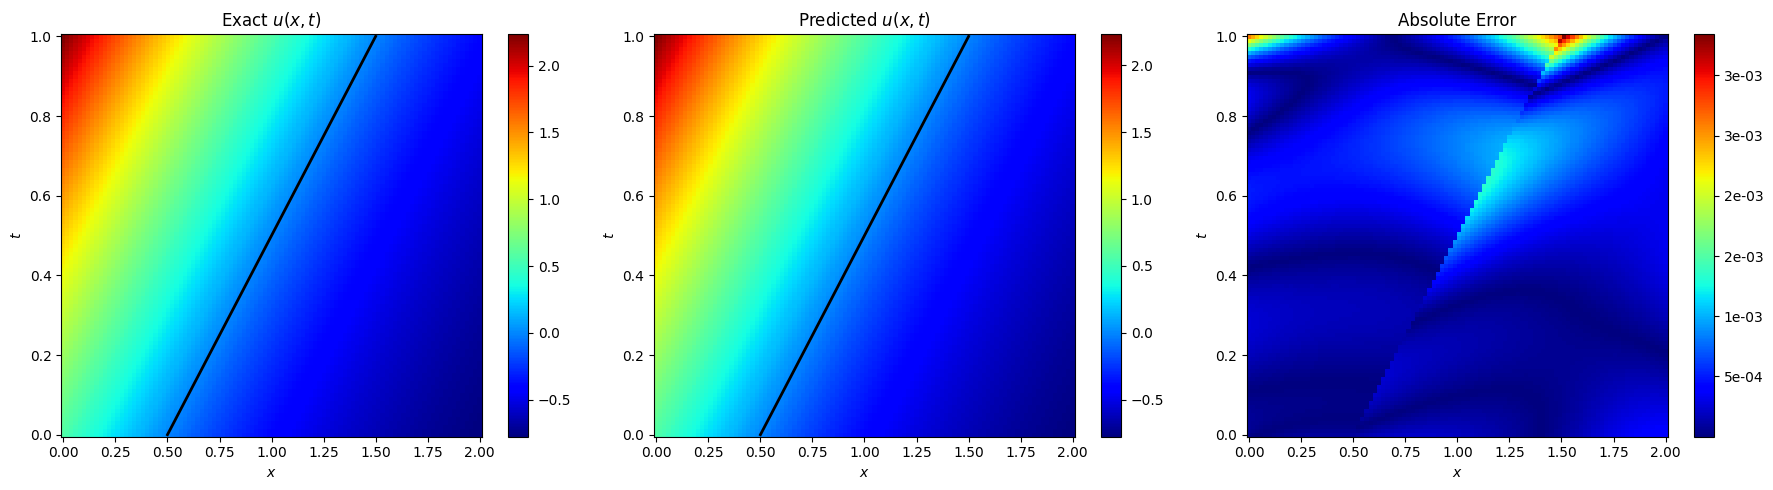

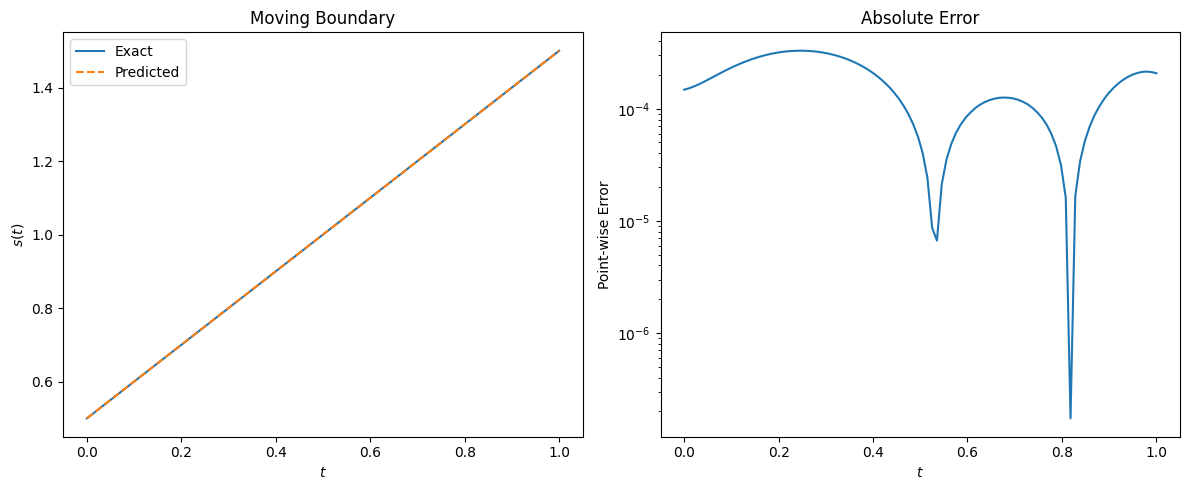

In [ ]:
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import seaborn as sns
#from Stefan1D_2p_models_tf import Sampler, DataSampler, Stefan1D_2P_direct
import pandas as pd
import os

if __name__ == '__main__':
    
    # Exact u1
    def u1(x):
        # x = (x, t)
        t = x[:, 1:2]  # compute t first! otherwise x is changed!
        x = x[:, 0:1]

        u1 = 2 * (np.exp((t + 0.5 - x) / 2) - 1)
        return u1

    # Exact u2
    def u2(x):
        # x = (x, t)
        t = x[:, 1:2]
        x = x[:, 0:1]

        u2 = np.exp(t + 0.5 - x) - 1
        return u2

    # Exact s
    def s(x):
        t = x[:, 1:2]
        s = t + 0.5
        return s
    
    # Exact u
    def u(x):
        return np.where(x[:, 0:1] <= s(x), u1(x), u2(x))

    # initial condition for u1
    def u1_0(x):
        x = x[:, 0:1]
        u1_0 = 2 * (np.exp((0.5 - x) / 2) - 1)
        return u1_0
    
    # initial condition for u2
    def u2_0(x):
        x = x[:, 0:1]
        u2 = np.exp(0.5 - x) - 1
        return u2
    
    
    def psi_1(x):
        t = x[:, 1:2]
        psi_1 = 2 * (np.exp((t + 0.5) / 2) - 1)
        return  psi_1

    def psi_2(x):
        t = x[:, 1:2]
        psi_2 = np.exp(t + 0.5 - 2) - 1
        return psi_2

    # initial condition for s
    def s_0(x):
        z = 0.5
        N = x.shape[0]
        return z * np.ones((N, 1))

    # Domain boundaries
    ics_coords = np.array([[0.0, 0.0],
                           [2.0, 0.0]])
    bc1_coords = np.array([[0.0, 0.0],
                           [0.0, 1.0]])
    bc2_coords = np.array([[2.0, 0.0],
                           [2.0, 1.0]])
    dom_coords = np.array([[0.0, 0.0],
                           [2.0, 1.0]])

    # Create boundary conditions samplers
    ic1_sampler = Sampler(2, ics_coords, lambda x: u1_0(x), name='Initial Condition')
    ic2_sampler = Sampler(2, ics_coords, lambda x: u2_0(x), name='Initial Condition')

    ics_sampler = [ic1_sampler, ic2_sampler]

    bc1_sampler = Sampler(2, bc1_coords, lambda x: psi_1(x), name='Boundary Condition')
    bc2_sampler = Sampler(2, bc2_coords, lambda x: psi_2(x), name='Boundary Condition')

    bcs_sampler = [bc1_sampler, bc2_sampler]

    # Create residual sampler
    res_sampler = Sampler(2, dom_coords, lambda x: u(x), name='Forcing')

    # Define model
    layers_u = [2, 100, 100, 100, 2]
    layers_s = [1, 100, 100, 100, 1]  # or we can map s to (t, s(t))
    model = Stefan1D_2P_direct(layers_u, layers_s, bcs_sampler, ics_sampler, res_sampler)
    
    # Train the model
    model.train(nIter=40000, batch_size=128)

    # Test data
    nn = 100
    x = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
    t = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
    X, T = np.meshgrid(x, t)
    X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    
    # Exact solutions
    u_star = u(X_star)
    s_star = s(X_star)

    # Predictions
    u_pred = model.predict_u(X_star)
    s_pred = model.predict_s(X_star)
    
    # Errors
    error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
    error_s = np.linalg.norm(s_star - s_pred, 2) / np.linalg.norm(s_star, 2)

    print('Relative L2 error_u: {:.2e}'.format(error_u))
    print('Relative L2 error_s: {:.2e}'.format(error_s))
    
    
    # Plot
    U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')
    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
    
    t = np.linspace(0,1, 100)[:, None]
    x = np.zeros_like(t)
    x_star = np.concatenate((x,t), axis=1)
    
    s_star = s(x_star)
    s_pred = model.predict_s(x_star)
    error_s = np.abs(s_star - s_pred)
    
    # Plot for solution u
    fig_1 = plt.figure(1, figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.plot(s_star, t, color='black', linewidth=2)
    plt.pcolor(X, T, U_star, cmap='jet')
    plt.colorbar()
    plt.xlabel(r'$x$')
    plt.ylabel(r'$t$')
    plt.title('Exact $u(x,t)$')
    
    plt.subplot(1, 3, 2)
    plt.pcolor(X, T, U_pred, cmap='jet')
    plt.plot(s_pred, t, color='black', linewidth=2)
    plt.colorbar()
    plt.xlabel(r'$x$')
    plt.ylabel(r'$t$')
    plt.title('Predicted $u(x,t)$')

    plt.subplot(1, 3, 3)
    plt.pcolor(X, T, np.abs(U_star - U_pred), cmap='jet')
    plt.colorbar(format='%.0e')
    plt.xlabel(r'$x$')
    plt.ylabel(r'$t$')
    plt.title('Absolute Error')
    
    plt.tight_layout()
    plt.show()

    # Plot for solution s
    fig_2 = plt.figure(2, figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(t, s_star, label='Exact')
    plt.plot(t, s_pred, '--', label='Predicted')
    plt.xlabel(r'$t$')
    plt.ylabel(r'$s(t)$')
    plt.title('Moving Boundary')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(t, error_s)
    plt.xlabel(r'$t$')
    plt.ylabel(r'Point-wise Error')
    plt.title('Absolute Error')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()
